# Malware Detection Using Reinforcement Learning

In [1]:
import time
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
from sklearn.utils import shuffle
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

### Loading Dataset

In [2]:
df = pd.read_csv('data.csv')
df.head()

Source  S_Port     Destination  D_Port  Packets  Bytes  \
0    172.30.6.255   57041   192.168.240.1    7680        3    198   
1    172.30.6.255   55638   35.186.249.84      80       86  67650   
2  172.30.15.2348   51682  192.168.121.37     443       95  82309   
3       10.0.2.15   50719  119.254.87.201      80       11   1582   
4  172.30.15.1555   50864   54.169.137.62      80       10   1888   

   Packets_sent  Bytes_sent  Packets_received  Bytes_received     Rel Start  \
0             3         198                 0               0   1596.993566   
1            34        3483                52           64167     36.448377   
2            34        3046                61           79263   5313.787170   
3             6         705                 5             877  25327.813510   
4             6         998                 4             890   3555.231347   

    Duration  Bits_sent_rate  Bits_received_rate      Label  
0   9.007770      175.848184            0.000000     Benign  
1  22.163850     1257.182304        23160.958050     Benign  
2   4.092096     5954.894509       154958.241400     Benign  
3   0.896225     6293.062568         7828.391308  Malicious  
4   1.830215     4362.329016         3890.253331     Benign

In [3]:
df['Label'].value_counts()

Benign       10016
Malicious     2740
Name: Label, dtype: int64

### Train and Test split

In [4]:
from sklearn.model_selection import train_test_split
feature_cols = ['Packets', 'Bytes','Packets_sent','Bytes_sent','Packets_received','Bytes_received','Bits_sent_rate','Bits_received_rate']
X = df[feature_cols] #Features
y = df.Label #target
X.describe()

Packets         Bytes  Packets_sent    Bytes_sent  \
count  12756.000000  1.275600e+04  12756.000000  1.275600e+04   
mean     106.548291  7.771246e+04     45.193634  6.710413e+03   
std     1035.648738  9.520789e+05    386.302412  6.579936e+04   
min        1.000000  5.400000e+01      0.000000  0.000000e+00   
25%       11.000000  1.528000e+03      6.000000  7.050000e+02   
50%       16.000000  2.882000e+03      9.000000  1.154000e+03   
75%       31.000000  9.749500e+03     16.000000  3.360250e+03   
max    65130.000000  6.326617e+07  22023.000000  5.674620e+06   

       Packets_received  Bytes_received  Bits_sent_rate  Bits_received_rate  
count      12756.000000    1.275600e+04    12756.000000        1.275600e+04  
mean          61.354657    7.100205e+04     4155.814185        2.360222e+04  
std          653.627652    9.255427e+05    12696.567473        1.731471e+05  
min            0.000000    0.000000e+00        0.000000        0.000000e+00  
25%            5.000000    7.170000e+02      208.816250        2.117688e+02  
50%            7.000000    1.081000e+03     1259.064762        1.800297e+03  
75%           15.000000    6.346000e+03     3749.825557        5.281123e+03  
max        43107.000000    6.180656e+07   406549.700200        1.001004e+07

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

### Data Preprocessing

In [6]:
from sklearn.preprocessing import normalize 

#Normal
X_train = normalize(X_train, norm = 'l1')
X_test = normalize(X_test, norm = 'l1')

y_train = y_train.map({'Benign': 0, 'Malicious': 1})
y_test = y_test.map({'Benign': 0, 'Malicious': 1})

In [7]:
X_train

array([[0.00235883, 0.46704862, 0.00126366, ..., 0.18070334, 0.03751229,
        0.02367281],
       [0.00235928, 0.4796307 , 0.00104427, ..., 0.36131844, 0.0088852 ,
        0.02713485],
       [0.00125446, 0.38472371, 0.00072627, ..., 0.29545883, 0.05291145,
        0.17513221],
       ...,
       [0.00683285, 0.46007832, 0.00379603, ..., 0.20346698, 0.03691097,
        0.02926669],
       [0.00120649, 0.17318557, 0.00065808, ..., 0.09586079, 0.2907582 ,
        0.36045768],
       [0.00116703, 0.16752173, 0.00063656, ..., 0.09272577, 0.29585108,
        0.3667714 ]])

In [8]:
y_test.value_counts()

0    3033
1     794
Name: Label, dtype: int64

### Using D-Tree Classifier

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

In [10]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [11]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9877188398223151


### Using Logistic Regression

In [12]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
y_pred_lr = logreg.predict(X_test)

In [13]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_lr))

Accuracy: 0.8400836164097204


### Using Neural Networks

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()

        self.fc1 = nn.Linear(8,30)
        self.fc2 = nn.Linear(30,2)

    def forward(self,x):
        x = self.fc1(x)
        x = torch.tanh(x)
        x = self.fc2(x)
        return x

    def predict(self,x):
        pred = F.softmax(self.forward(x),dim=1)
        ans = []
        for t in pred:
            if t[0]>t[1]:
                ans.append(0)
            else:
                ans.append(1)
        return torch.tensor(ans)

In [15]:
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [16]:
train_X = torch.Tensor(X_train)
train_y = torch.from_numpy(y_train.values)
test_X = torch.Tensor(X_test)
test_y = torch.from_numpy(y_test.values)

In [17]:
epochs = 500
losses = []
for i in range(epochs):
    y_pred = model.forward(train_X.float())
    loss = criterion(y_pred,train_y)
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [18]:
from sklearn.metrics import accuracy_score
print(accuracy_score(model.predict(test_X.float()),test_y))

0.951397961850013


### Using Reinforcement Learning - Q Network

##### Creating DataFrames for your training and testing data

In [19]:
column_names = ['Packets', 'Bytes','Packets_sent','Bytes_sent','Packets_received','Bytes_received','Bits_sent_rate','Bits_received_rate']

X_train = pd.DataFrame(X_train, columns = column_names)
X_test = pd.DataFrame(X_test, columns = column_names)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [20]:
X_train

Packets     Bytes  Packets_sent  Bytes_sent  Packets_received  \
0     0.002359  0.467049      0.001264    0.286345          0.001095   
1     0.002359  0.479631      0.001044    0.118312          0.001315   
2     0.001254  0.384724      0.000726    0.089265          0.000528   
3     0.001265  0.468217      0.000660    0.109920          0.000605   
4     0.001195  0.407397      0.000661    0.093659          0.000534   
...        ...       ...           ...         ...               ...   
8924  0.001351  0.272881      0.000811    0.109423          0.000540   
8925  0.001052  0.151616      0.000574    0.067438          0.000478   
8926  0.006833  0.460078      0.003796    0.256611          0.003037   
8927  0.001206  0.173186      0.000658    0.077325          0.000548   
8928  0.001167  0.167522      0.000637    0.074796          0.000530   

      Bytes_received  Bits_sent_rate  Bits_received_rate  
0           0.180703        0.037512            0.023673  
1           0.361318        0.008885            0.027135  
2           0.295459        0.052911            0.175132  
3           0.358297        0.014329            0.046708  
4           0.313738        0.042029            0.140788  
...              ...             ...                 ...  
8924        0.163459        0.181061            0.270474  
8925        0.084178        0.308983            0.385681  
8926        0.203467        0.036911            0.029267  
8927        0.095861        0.290758            0.360458  
8928        0.092726        0.295851            0.366771  

[8929 rows x 8 columns]

##### Creating MDP (Markov decision process ) Environment

In [21]:
class Environment1:
    
    # initializes the environment
    def __init__(self, data, label, history_t = 8):
        self.label = label
        self.data = data
        self.history_t = history_t
        self.reset()
        
    # It returns the initial observation (history) to the agent.
    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 0
        self.position = []
        self.history = []
        self.history = [0 for _ in range(self.history_t)]
        return self.history #obs

    # Takes a step in the environment given an action act (an integer value). 
    # It calculates the reward based on the absolute difference between the action and the label at the current time step. 
    def step(self, act):
        reward = abs(act - self.label.iloc[self.t,:]['Label'])
        if reward > 0:
            reward = -1
        else:
            reward = 1
    
        self.t += 1

        self.history = []
        self.history.append(self.data.iloc[self.t, : ]['Packets'])
        self.history.append(self.data.iloc[self.t, : ]['Bytes'])
        self.history.append(self.data.iloc[self.t, : ]['Packets_sent'])
        self.history.append(self.data.iloc[self.t, : ]['Bytes_sent'])
        self.history.append(self.data.iloc[self.t, : ]['Packets_received'])
        self.history.append(self.data.iloc[self.t, : ]['Bytes_received'])
        self.history.append(self.data.iloc[self.t, : ]['Bits_sent_rate'])
        self.history.append(self.data.iloc[self.t, : ]['Bits_received_rate'])

        if (self.t==len(self.data)-1):
            self.done = True

        return self.history, reward, self.done

In [22]:
env = Environment1(X_train, y_train)

##### Deep Q Network

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#  initializes the neural network layers
class Q_Network(nn.Module):
    def __init__(self, obs_len, hidden_size, actions_n):
        super(Q_Network,self).__init__()

        # ReLU activation is applied to the hidden layer, 
        # and a Softmax activation is applied to the output layer to convert the raw scores into action probabilities.
        self.fc_val = nn.Sequential(
        nn.Linear(obs_len, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, actions_n),
        nn.Softmax(dim=1)
    )
    
    # Output converted to action probabilities in the range [0, 1] using Softmax.
    def forward(self, x):
        h = self.fc_val(x)
        return (h)

In [24]:
input_size = 8
output_size = 2
hidden_size = 50
USE_CUDA = False
LR = 0.001

In [25]:
# Initializes the Q-network 
Q = Q_Network(input_size, hidden_size, output_size)

In [26]:
# Creates a deep copy of the Q-network for use as the target Q-network.
Q_ast = copy.deepcopy(Q)

In [27]:
if USE_CUDA:
    Q = Q.cuda()
# calculating the loss between predicted Q-values and target Q-values.
loss_function = nn.MSELoss()

# updating the Q-network parameters during training.
optimizer = optim.Adam(list(Q.parameters()), lr=LR)

##### Deep Q Learning

In [28]:
epoch_num = 30
step_max = len(env.data)
memory_size = 32
batch_size = 8
gamma = 0.97

In [29]:
memory = []  #Replay Memory
total_step = 0
total_rewards = []
total_losses = []
epsilon = 1.0  #exploration rate
epsilon_decrease = 1e-3
epsilon_min = 0.1
start_reduce_epsilon = 200
train_freq = 10 # The frequency (in steps) at which to perform a training update.
update_q_freq = 20 # The frequency(in steps) at which to update the target Q-network.
gamma = 0.97  #discount rate
show_log_freq = 5 # The frequency (in epochs) at which to display training logs.

In [30]:
# Calculate accuracy in each epoch
accuracy_per_epoch = []

In [31]:
def testing():
    test_env = Environment1(X_test,y_test)
    pobs = test_env.reset()
    test_acts = []
    test_rewards = []
    current_cash_in_hand = []

    for _ in range(len(test_env.data)-1):
        pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
        pact = np.argmax(pact.data)
        test_acts.append(pact.item())
        
            
        obs, reward, done = test_env.step(pact.numpy())
        test_rewards.append(reward)

        pobs = obs
    
    test_acts.append(0)
  

    accuracy_per_epoch.append(metrics.accuracy_score(y_test,test_acts))

In [32]:
start = time.time()
for epoch in range(epoch_num):
    print(epoch+1)
    pobs = env.reset()
    step = 0
    done = False
    total_reward = 0
    total_loss = 0

    while not done and step < step_max:

        # select act using exploration
        pact = np.random.randint(2)

        # select act using exploitation
        if np.random.rand() > epsilon:
            pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
            pact = np.argmax(pact.data)
            pact = pact.numpy()

        # act
        obs, reward, done = env.step(pact)

        # add memory
        memory.append((pobs, pact, reward, obs, done))
        if len(memory) > memory_size:
            memory.pop(0)
        
        # train or update q
        if len(memory) == memory_size:
            if total_step % train_freq == 0:
                shuffled_memory = np.random.permutation(memory)   #taking random samples in order to break the correlation between consecutive samples
                memory_idx = range(len(shuffled_memory))
                for i in memory_idx[::batch_size]:
                    batch = np.array(shuffled_memory[i:i+batch_size])
                    b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                    b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                    b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                    b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                    b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                    q = Q(torch.from_numpy(b_pobs))
                    q_ = Q_ast(torch.from_numpy(b_obs))
                    maxq = np.max(q_.data.numpy(),axis=1)
                    target = copy.deepcopy(q.data)
                    for j in range(batch_size):
                        target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])   #Bellman equation
                    Q.zero_grad() #clear the previous gradients
                    loss = loss_function(q, target) #compute loss
                    total_loss += loss.data.item()
                    loss.backward() #compute gradients
                    optimizer.step()  #adjust weights
                    
            if total_step % update_q_freq == 0:
                Q_ast = copy.deepcopy(Q)
                
            # update epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            elapsed_time = time.time()-start
            print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss, elapsed_time])))
            start = time.time()
    
    testing()
#return Q, total_losses, total_rewards

1
2
3
4
5
5	0.0999999999999992	35682	23401718.0	5678094.280956781	66.31978225708008
5	0.0999999999999992	35683	23401718.4	5678094.280956781	0.0
5	0.0999999999999992	35684	23401719.0	5678094.280956781	0.0
5	0.0999999999999992	35685	23401719.8	5678094.280956781	0.0
5	0.0999999999999992	35686	23401720.8	5678094.280956781	0.0
5	0.0999999999999992	35687	23401722.0	5678094.280956781	0.0
5	0.0999999999999992	35688	23401723.4	5678094.280956781	0.0
5	0.0999999999999992	35689	23401724.6	5678094.280956781	0.015625476837158203
5	0.0999999999999992	35690	23401726.0	5678094.280956781	0.0
5	0.0999999999999992	35691	23401727.2	5678094.624573225	0.0
5	0.0999999999999992	35692	23401728.6	5678094.968189669	0.0
5	0.0999999999999992	35693	23401730.2	5678095.3118061125	0.0
5	0.0999999999999992	35694	23401732.0	5678095.655422556	0.01563739776611328
5	0.0999999999999992	35695	23401734.0	5678095.999039	0.0
5	0.0999999999999992	35696	23401736.2	5678096.3426554445	0.0
5	0.0999999999999992	35697	23401738.6	567809

In [33]:
print(accuracy_per_epoch[29])

0.966553436111837


In [34]:
print(accuracy_per_epoch)

[0.9114188659524431, 0.9472171413639927, 0.9566239874575385, 0.964724327149203, 0.9657695322707082, 0.9655082309903319, 0.967598641233342, 0.9683825450744709, 0.9668147373922132, 0.9683825450744709, 0.9657695322707082, 0.9691664489155997, 0.9699503527567285, 0.9655082309903319, 0.970472955317481, 0.970472955317481, 0.9707342565978573, 0.9707342565978573, 0.970472955317481, 0.9712568591586099, 0.9655082309903319, 0.9725633655604913, 0.9720407629997387, 0.9696890514763522, 0.9702116540371047, 0.970472955317481, 0.9712568591586099, 0.9712568591586099, 0.9720407629997387, 0.966553436111837]


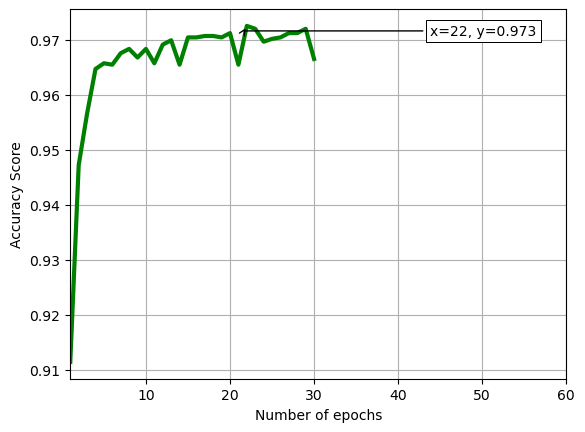

In [35]:
import matplotlib.pyplot as plt 

x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]#,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61]
y = accuracy_per_epoch

plt.plot(x, y, color='green', linewidth = 3)
plt.xlim(1,60)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy Score')
plt.grid(True)

def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = max(y)
    text= "x={:}, y={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

annot_max(x,y)

plt.savefig('accuracy_graph.png')